In [ ]:
!pip install -U tensorflow
!pip install -U sklearn

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import nltk
nltk.download('punkt')

tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/FakeNewsDetection/"

Mounted at /content/gdrive


In [ ]:
# Pre-process data 
def pre_process(news_data):
    # Merge title with text
    news_data["text"] = news_data["title"] + " " + news_data["text"]

    # Remove useless columns
    news_data.drop(["title"],axis=1,inplace=True)

    # Remove digits
    news_data['text'] = news_data['text'].apply(remove_digits)

    # Remove punctuation
    news_data['text'] = news_data['text'].apply(remove_punctuation)

    # Convert to lowercase
    news_data['text'] = news_data['text'].apply(lambda x: x.lower())

    # Remove stop words
    english_stopwords = stopwords.words('english')
    news_data['text'] = news_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_stopwords)]))

    # Stemming
    stemmer= PorterStemmer()
    for x in news_data['text']:
        x = word_tokenize(x)
        y = ""
        for word in x:
            y = y + stemmer.stem(word)
            y = y + " "
        x = y

    # Remove leading and ending spaces
    news_data['text'] = news_data['text'].apply(lambda x: x.strip())
    return news_data

In [ ]:
# Pre-process data 
def pre_process_2(news_data):
    # Remove digits
    news_data['content'] = news_data['content'].apply(remove_digits)

    # Remove punctuation
    news_data['content'] = news_data['content'].apply(remove_punctuation)

    # Convert to lowercase
    news_data['content'] = news_data['content'].apply(lambda x: x.lower())

    # Remove stop words
    english_stopwords = stopwords.words('english')
    news_data['content'] = news_data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (english_stopwords)]))

    # Stemming
    stemmer= PorterStemmer()
    for x in news_data['content']:
        x = word_tokenize(x)
        y = ""
        for word in x:
            y = y + stemmer.stem(word)
            y = y + " "
        x = y

    # Remove leading and ending spaces
    news_data['content'] = news_data['content'].apply(lambda x: x.strip())
    return news_data

In [ ]:
# Useful methods

token_space = tokenize.WhitespaceTokenizer()

def remove_punctuation(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

def remove_digits(text):
    all_list = [char for char in str(text) if char not in string.digits]
    clean_str = ''.join(all_list)
    return clean_str

def count_words_frequency(text, column_text, quantity):
    words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# DATASET 1

In [ ]:
#Dataset 1

fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true


In [ ]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
# Clean data
#   without -> acc. 99
#   with -> acc. 93

# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",true


In [ ]:
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)

Group by label:
---------------
label
fake    23481
true    21417
Name: text, dtype: int64


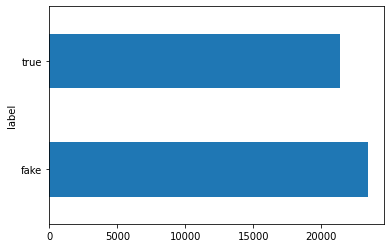

Group by subject:
-----------------
subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


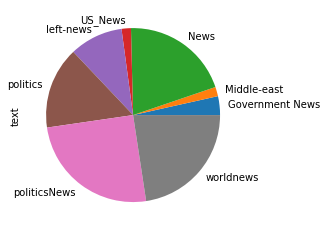

In [ ]:
# Data analysis 

print("Group by label:")
print("---------------")
print(news_data.groupby(['label'])['text'].count())
news_data.groupby(['label'])['text'].count().plot(kind='barh')
plt.show()

print("Group by subject:")
print("-----------------")
print(news_data.groupby(['subject'])['text'].count())
news_data.groupby(['subject'])['text'].count().plot(kind="pie")
plt.show()

In [ ]:
news_data = pre_process(news_data)
news_data.drop(["subject"],axis=1,inplace=True)
news_data.drop(["date"],axis=1,inplace=True)


In [ ]:
news_data.head()

,text,label
0,democrats may save oregon’s middle class gop n...,fake
1,trump finally admitted something really hasn’t...,fake
2,democratic congressman schiff says trumpputin ...,true
3,factbox raqqa battle islamic states syrian hq ...,true
4,fbi director smacked smug look trey gowdy’s fa...,fake


Wordcloud for true news:
------------------------


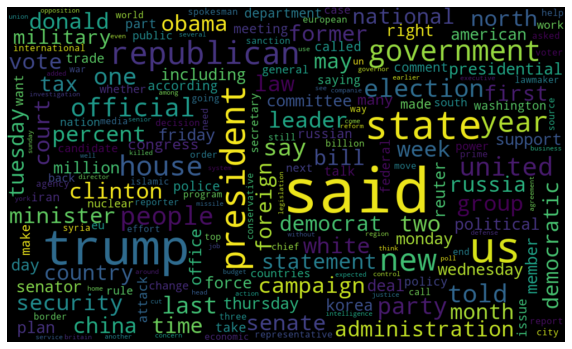

Wordcloud for fake news:
------------------------


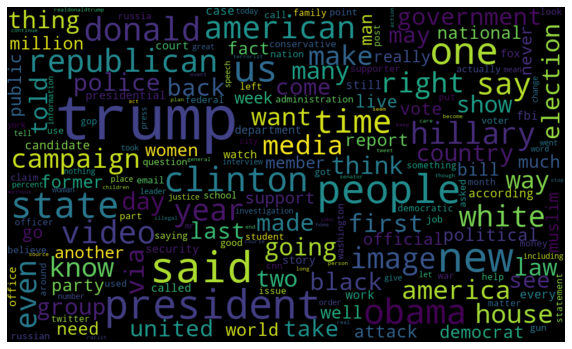

In [ ]:
# Data analysis 

# Wordcloud for true news
print("Wordcloud for true news:")
print("------------------------")
true_news = news_data[news_data["label"] == "true"]
all_words = ' '.join([text for text in true_news.text])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Wordcloud for false news
print("Wordcloud for fake news:")
print("------------------------")
fake_news = news_data[news_data["label"] == "fake"]
all_words = ' '.join([text for text in fake_news.text])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



Most frequent 30 words in true news
-----------------------------------


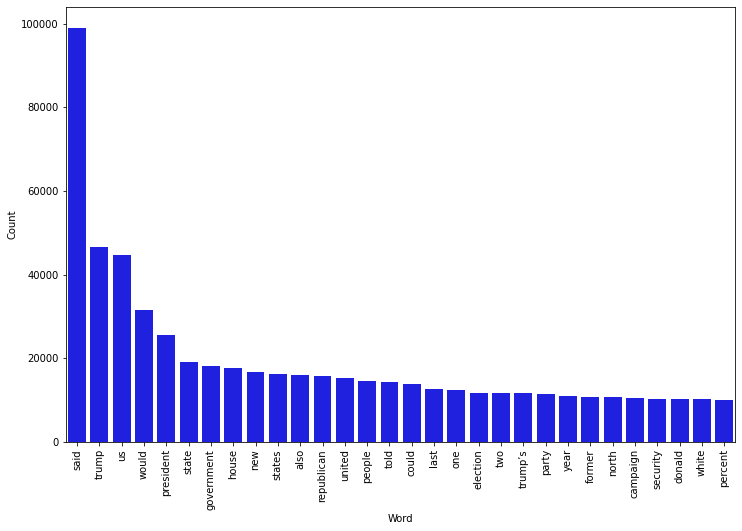

Most frequent 30 words in false news
-----------------------------------


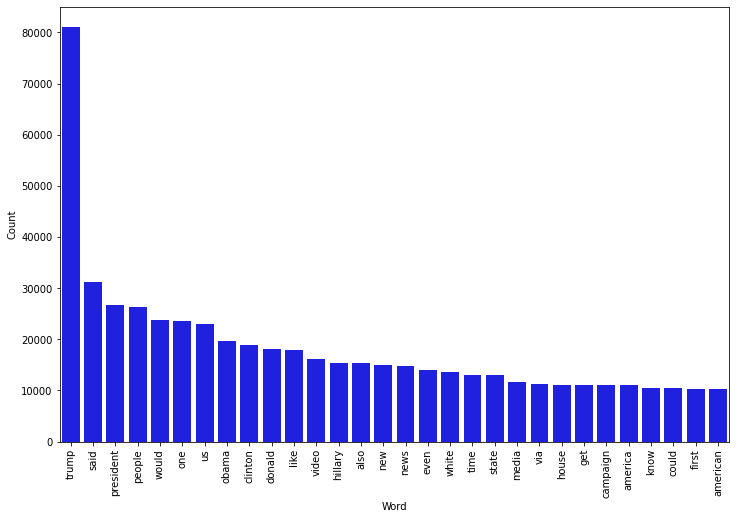

In [ ]:
# Most frequent 30 words in true news
print("Most frequent 30 words in true news")
print("-----------------------------------")
count_words_frequency(news_data[news_data["label"] == "true"], "text", 30)

# Most frequent 30 words in false news
print("Most frequent 30 words in false news")
print("-----------------------------------")
count_words_frequency(news_data[news_data["label"] == "fake"], "text", 30)

In [ ]:
# Modelling

X_train,X_test,Y_train,Y_test = train_test_split(news_data['text'], news_data.label, test_size=0.25, random_state=42)


# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(X_train, Y_train)

# Metrics
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(Y_test, prediction)*100,2)))
print(classification_report(Y_test, prediction))


accuracy: 94.27%
              precision    recall  f1-score   support

        fake       0.95      0.94      0.95      5873
        true       0.94      0.94      0.94      5352

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



In [ ]:
prediction

array(['true', 'fake', 'fake', ..., 'fake', 'fake', 'fake'], dtype=object)

Confusion matrix, without normalization


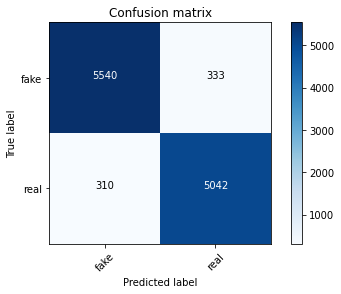

In [ ]:
cm = metrics.confusion_matrix(Y_test, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4])

# DATASET 2

In [ ]:
# Dataset 2
X_train_2 = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_train_2 = shuffle(X_train_2)
X_train_2 = X_train_2.reset_index(drop=True)

In [ ]:
X_train_2.head()

,id,title,author,text,label
0,12580,Iraqi Christians Return to Charred Churches Ca...,NaN,Iraqi Christians Return to Charred Churches Ca...,1
1,18801,Russian scientists to track sea lions from space,TASS,Russian scientists to track sea lions from spa...,1
2,9374,Marine Le Pen Echoes Trump’s Bleak Populism in...,Adam Nossiter,"LYON, France — The French leader Marine L...",0
3,9098,Refugees Will Cost Taxpayers an Estimated $4.1...,Michael Patrick Leahy,American taxpayers will spend more than $4. 1 ...,0
4,5766,¿Qué hacer si tu pareja se muda a tu piso?,Redacción,¿Qué hacer si tu pareja se muda a tu piso? CON...,1


Group by label:
---------------
label
0    10387
1    10374
Name: text, dtype: int64


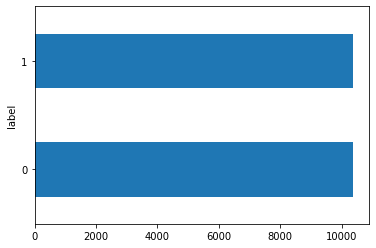

In [ ]:
print("Group by label:")
print("---------------")
print(X_train_2.groupby(['label'])['text'].count())
X_train_2.groupby(['label'])['text'].count().plot(kind='barh')
plt.show()

In [ ]:
X_train_2 = pre_process(X_train_2)
X_train_2.drop(["author"],axis=1,inplace=True)
X_train_2.drop(["id"],axis=1,inplace=True)

In [ ]:
X_train_2.head()

,text,label
0,iraqi christians return charred churches captu...,1
1,russian scientists track sea lions space russi...,1
2,marine le pen echoes trump’s bleak populism fr...,0
3,refugees cost taxpayers estimated billion fy b...,0
4,¿qué hacer si tu pareja se muda tu piso ¿qué h...,1


Wordcloud for true news:
------------------------


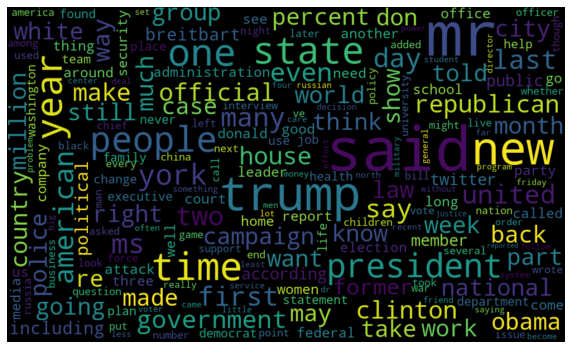

Wordcloud for fake news:
------------------------


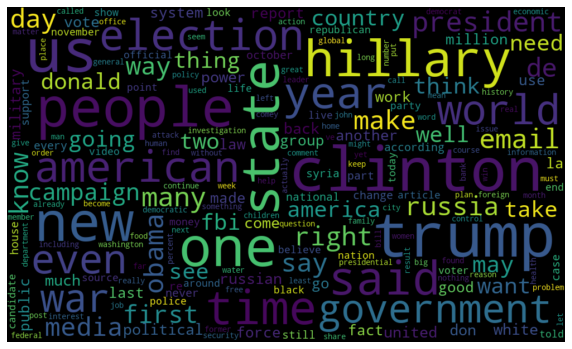

In [ ]:
# Data analysis 
# true = 0, false = 1

# Wordcloud for true news
print("Wordcloud for true news:")
print("------------------------")
true_news = X_train_2[X_train_2["label"] == 0]
all_words = ' '.join([text for text in true_news.text])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Wordcloud for false news
print("Wordcloud for fake news:")
print("------------------------")
fake_news = X_train_2[X_train_2["label"] == 1]
all_words = ' '.join([text for text in fake_news.text])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Most frequent 30 words in true news
-----------------------------------


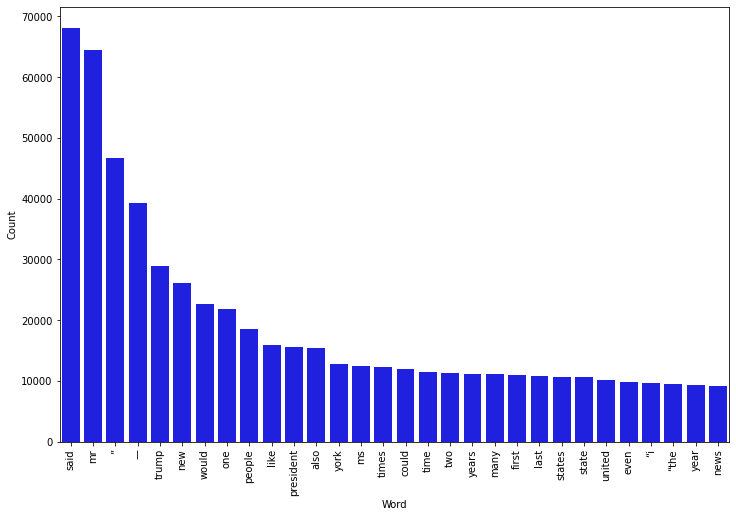

Most frequent 30 words in false news
-----------------------------------


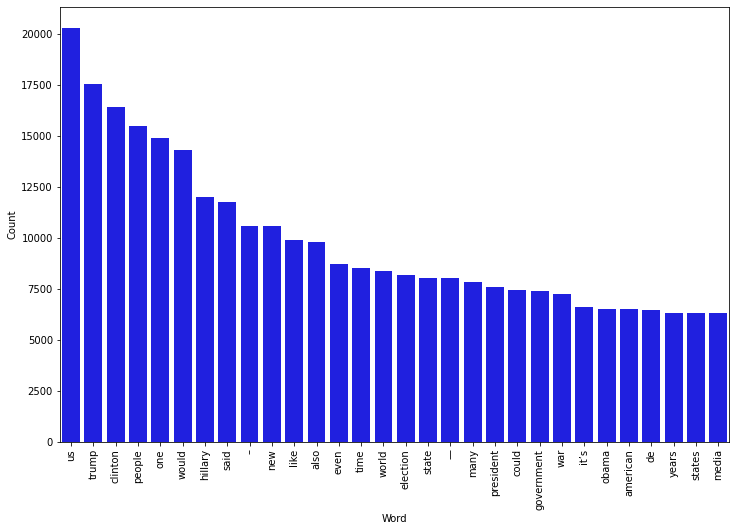

In [ ]:
# Most frequent 30 words in true news
print("Most frequent 30 words in true news")
print("-----------------------------------")
count_words_frequency(X_train_2[X_train_2["label"] == 0], "text", 30)

# Most frequent 30 words in false news
print("Most frequent 30 words in false news")
print("-----------------------------------")
count_words_frequency(X_train_2[X_train_2["label"] == 1], "text", 30)

In [ ]:
# Modelling
X_train_2,X_test_2,Y_train_2,Y_test_2 = train_test_split(X_train_2['text'], X_train_2.label, test_size=0.25, random_state=42)


# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(X_train_2, Y_train_2)

# Metrics
prediction = model.predict(X_test_2)
print("accuracy: {}%".format(round(accuracy_score(Y_test_2, prediction)*100,2)))
print(classification_report(Y_test_2, prediction))


accuracy: 94.42%
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2616
           1       0.94      0.94      0.94      2584

    accuracy                           0.94      5200
   macro avg       0.94      0.94      0.94      5200
weighted avg       0.94      0.94      0.94      5200



Confusion matrix, without normalization


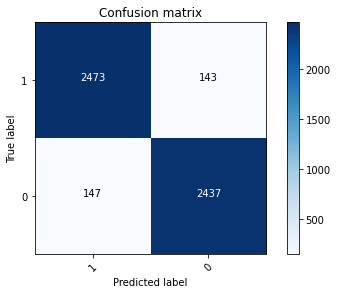

In [ ]:
cm = metrics.confusion_matrix(Y_test_2, prediction)
confusion_matrix(cm, classes=[1, 0])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4])

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4])

# DATASET 3

In [ ]:
def read_data(skip: int):
    tp = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_2018_02_13.csv"), 
                        skiprows = skip,
                        nrows=1000000, 
                        chunksize = 100,
                        lineterminator='\n', 
                        encoding = 'ISO-8859-1',
                        names=['id','domain','type','url','content','scraped_at','inserted_at','updated_at','title','authors', 'keywords', 'meta_keywords', 'meta_description', 'tags', 'summary', 'source'])
                        #  dtype={'id': int, 'type': str, 'url': str, 'content':str, 'scraped_at':str, 'inserted_at': str, 'updated_at':str, 'title':str, 'authors':str, 'keywords':str, 'meta_keywords':str, 'meta_description':str, 'tags': str, 'summary': str, 'source':str})
    df = pd.concat(tp, ignore_index=True) 
    df.drop(["id"],axis=1,inplace=True)
    df.drop(["domain"],axis=1,inplace=True)
    df.drop(["url"],axis=1,inplace=True)
    df.drop(["scraped_at"],axis=1,inplace=True)
    df.drop(["inserted_at"],axis=1,inplace=True)
    df.drop(["updated_at"],axis=1,inplace=True)
    df.drop(["authors"],axis=1,inplace=True)
    df.drop(["keywords"],axis=1,inplace=True)
    df.drop(["meta_keywords"],axis=1,inplace=True)
    df.drop(["meta_description"],axis=1,inplace=True)
    df.drop(["tags"],axis=1,inplace=True)
    df.drop(["summary"],axis=1,inplace=True)
    df.drop(["source"],axis=1,inplace=True)
    del tp
    df = df.loc[(df.type == 'fake') | (df.type == 'unreliable') | (df.type == 'reliable')]
    return df


In [ ]:
# df = read_data(0)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_1.csv"), index=False) 

# df = read_data(1000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_2.csv"), index=False) 

# df = read_data(2000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_3.csv"), index=False) 

# df = read_data(3000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_4.csv"), index=False) 

# df = read_data(4000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_5.csv"), index=False) 

# df = read_data(5000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_6.csv"), index=False) 

# df = read_data(6000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_7.csv"), index=False) 

# df = read_data(7000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_8.csv"), index=False) 

# df = read_data(8000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_9.csv"), index=False) 

# df = read_data(9000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_10.csv"), index=False) 


In [ ]:
# df = read_data(10000000)
# df.to_csv(os.path.join(PATH, "Dataset3/news_cleaned_11.csv"), index=False) 

In [ ]:
df = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_1.csv"))
df['type'] = df['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
df["content"] = df["title"] + " " + df["content"]
df.drop(["title"],axis=1,inplace=True)

df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_2.csv"))
df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
df2["content"] = df2["title"] + " " + df2["content"]
df2.drop(["title"],axis=1,inplace=True)
df = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_3.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# df = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_4.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# df = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_5.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# df = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_6.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# df = pd.concat([df, df2])

df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_7.csv"))
df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
df2["content"] = df2["title"] + " " + df2["content"]
df2.drop(["title"],axis=1,inplace=True)
result = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_8.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# df = pd.concat([df, df2])

# df2 = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_9.csv"))
# df2['type'] = df2['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
# df2["content"] = df2["title"] + " " + df2["content"]
# df2.drop(["title"],axis=1,inplace=True)
# result = pd.concat([df, df2])

del df, df2

Group by subject:
-----------------
type
fake    417559
true    363762
Name: content, dtype: int64


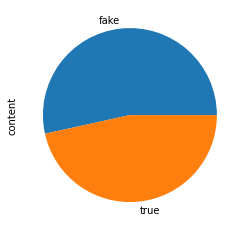

In [ ]:
print("Group by subject:")
print("-----------------")
print(result.groupby(['type'])['content'].count())
result.groupby(['type'])['content'].count().plot(kind="pie")
plt.show()

In [ ]:
result = shuffle(result)
result = result.reset_index(drop=True)

In [ ]:
result.head()

,type,content
0,true,"For a Horse of the World, a Finale in a Regal ..."
1,true,Telling Folk Heroes From Monsters Photo\n\nWoe...
2,fake,12 Email Marketing Tips for Professionals â ...
3,fake,Shock Footage: Officer Run Over During Police ...
4,fake,Musical Chairs In The Retail Space Headline: B...


In [ ]:
result = pre_process_2(result)

In [ ]:
result.head()

,text,label
0,us puts pressure pakistan help afghan war unit...,true
1,going secret service st century wire says stri...,fake
2,frances macron give saudi arabia extremist lis...,true
3,new york governor unveils south bronx highway ...,true
4,trump’s lawyer destroys chriswallace heated ex...,fake


Wordcloud for true news:
------------------------


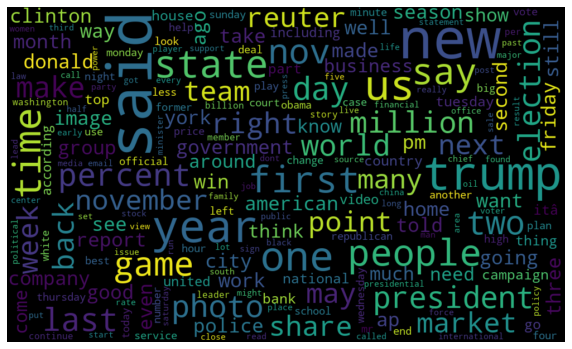

Wordcloud for fake news:
------------------------


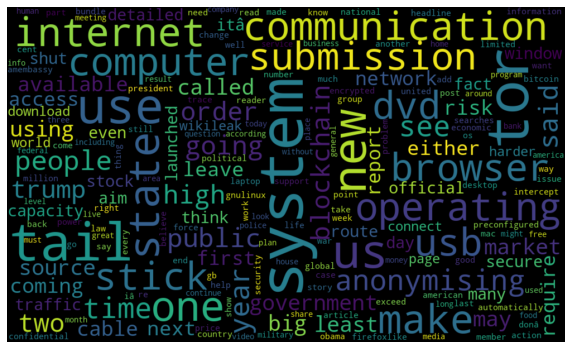

In [ ]:
# Data analysis 

# Wordcloud for true news
print("Wordcloud for true news:")
print("------------------------")
true_news = result[result["type"] == "true"]
all_words = ' '.join([text for text in true_news.content])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Wordcloud for false news
print("Wordcloud for fake news:")
print("------------------------")
fake_news = result[result["type"] == "fake"]
all_words = ' '.join([text for text in fake_news.content])
wordcloud = WordCloud(width= 1000, height= 600, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



Most frequent 30 words in true news
-----------------------------------


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0, flags=flags)


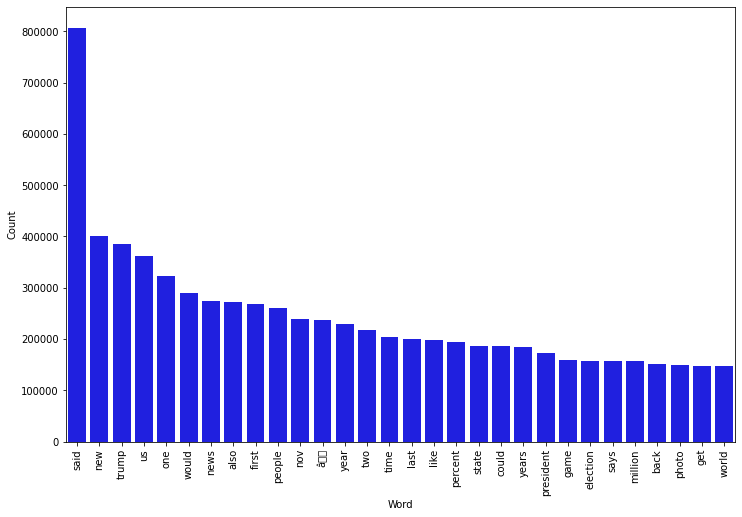

Most frequent 30 words in false news
-----------------------------------


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


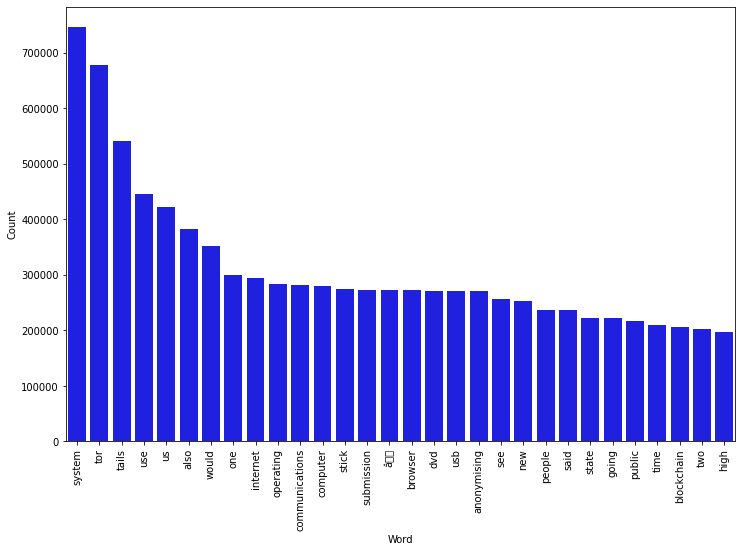

In [ ]:
# Most frequent 30 words in true news
print("Most frequent 30 words in true news")
print("-----------------------------------")
count_words_frequency(result[result["type"] == "true"], "content", 30)

# Most frequent 30 words in false news
print("Most frequent 30 words in false news")
print("-----------------------------------")
count_words_frequency(result[result["type"] == "fake"], "content", 30)

In [ ]:
# Modelling

X_train,X_test,Y_train,Y_test = train_test_split(result['content'], result['type'], test_size=0.25, random_state=42)


# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(X_train, Y_train)

# Metrics
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(Y_test, prediction)*100,2)))
print(classification_report(Y_test, prediction))


accuracy: 92.88%
              precision    recall  f1-score   support

        fake       0.97      0.90      0.93    104350
        true       0.89      0.96      0.93     91016

    accuracy                           0.93    195366
   macro avg       0.93      0.93      0.93    195366
weighted avg       0.93      0.93      0.93    195366



Confusion matrix, without normalization


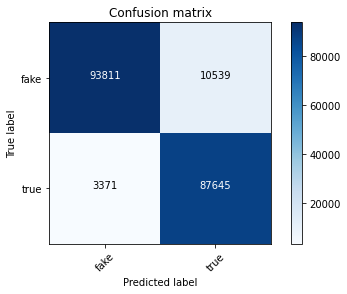

In [ ]:
cm = metrics.confusion_matrix(Y_test, prediction)
confusion_matrix(cm, classes=['fake', 'true'])

# Transfer learning

## Dataset 1 - Dataset 2

In [ ]:
#Dataset 1

fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
# Clean data

# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)

In [ ]:
news_data = pre_process(news_data)
news_data.drop(["subject"],axis=1,inplace=True)
news_data.drop(["date"],axis=1,inplace=True)


In [ ]:
# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(news_data['text'], news_data.label)


In [ ]:
# Dataset 2
X_test = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process(X_test)
X_test.drop(["author"],axis=1,inplace=True)
X_test.drop(["id"],axis=1,inplace=True)

In [ ]:
# Metrics
prediction = model.predict(X_test["text"])

In [ ]:
prediction2 = np.array([0 if i  == "true" else 1 for i in prediction])
prediction2

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(X_test["label"], prediction2)*100,2)))
print(classification_report(X_test["label"], prediction2))

accuracy: 69.1%
              precision    recall  f1-score   support

           0       0.75      0.57      0.65     10387
           1       0.66      0.81      0.72     10413

    accuracy                           0.69     20800
   macro avg       0.70      0.69      0.69     20800
weighted avg       0.70      0.69      0.69     20800



Confusion matrix, without normalization


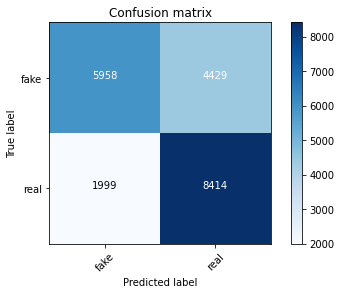

In [ ]:
cm = metrics.confusion_matrix(X_test["label"], prediction2)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 1 - Dataset 3

In [ ]:
X_test = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process_2(X_test)

In [ ]:
# Metrics
prediction = model.predict(X_test["content"])

In [ ]:
len(prediction)

50001

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(X_test["type"], prediction)*100,2)))
print(classification_report(X_test["type"], prediction))

accuracy: 64.01%
              precision    recall  f1-score   support

        fake       0.59      0.89      0.71     24729
        true       0.78      0.40      0.53     25272

    accuracy                           0.64     50001
   macro avg       0.69      0.64      0.62     50001
weighted avg       0.69      0.64      0.62     50001



Confusion matrix, without normalization


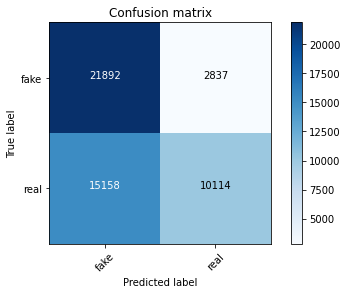

In [ ]:
cm = metrics.confusion_matrix(X_test["type"], prediction)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 2 - Dataset 1

In [ ]:
# Dataset 2
news_data = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)

In [ ]:
news_data = pre_process(news_data)
news_data.drop(["author"],axis=1,inplace=True)
news_data.drop(["id"],axis=1,inplace=True)

In [ ]:
# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(news_data['text'], news_data.label)


In [ ]:
#Dataset 1

fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
# Clean data

# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
X_test = pd.concat([fake_data, true_data]).reset_index(drop = True)
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process(X_test)
X_test.drop(["subject"],axis=1,inplace=True)
X_test.drop(["date"],axis=1,inplace=True)


In [ ]:
# Metrics
prediction = model.predict(X_test["text"])

In [ ]:
Y2 = np.array([0 if i  == "true" else 1 for i in X_test['label']])


In [ ]:
print("accuracy: {}%".format(round(accuracy_score(Y2, prediction)*100,2)))
print(classification_report(Y2, prediction))

accuracy: 56.78%
              precision    recall  f1-score   support

           0       0.61      0.26      0.37     21417
           1       0.56      0.85      0.67     23481

    accuracy                           0.57     44898
   macro avg       0.58      0.55      0.52     44898
weighted avg       0.58      0.57      0.53     44898



Confusion matrix, without normalization


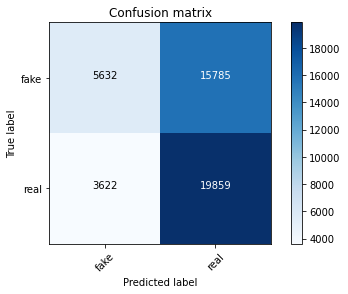

In [ ]:
cm = metrics.confusion_matrix(Y2, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 2 - Dataset 3

In [ ]:
X_test = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process_2(X_test)

In [ ]:
# Metrics
prediction = model.predict(X_test["content"])

In [ ]:
Y2 = np.array([0 if i  == "true" else 1 for i in X_test['type']])


In [ ]:
print("accuracy: {}%".format(round(accuracy_score(Y2, prediction)*100,2)))
print(classification_report(Y2, prediction))

accuracy: 61.03%
              precision    recall  f1-score   support

           0       0.84      0.28      0.42     25272
           1       0.56      0.94      0.71     24729

    accuracy                           0.61     50001
   macro avg       0.70      0.61      0.57     50001
weighted avg       0.70      0.61      0.56     50001



Confusion matrix, without normalization


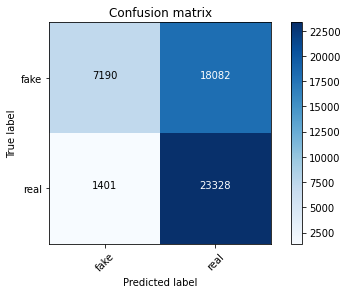

In [ ]:
cm = metrics.confusion_matrix(Y2, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 3 - Dataset 1

In [ ]:
news_data = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)

In [ ]:
news_data = pre_process_2(news_data)

In [ ]:
# Vectorizing & TF-IDF
model = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth = 20, splitter='best', random_state=42))])

# Fit the model
history = model.fit(news_data['content'], news_data.type)


In [ ]:
#Dataset 1

fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
# Clean data

# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
X_test = pd.concat([fake_data, true_data]).reset_index(drop = True)
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process(X_test)
X_test.drop(["subject"],axis=1,inplace=True)
X_test.drop(["date"],axis=1,inplace=True)


In [ ]:
# Metrics
prediction = model.predict(X_test["text"])

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(X_test['label'], prediction)*100,2)))
print(classification_report(X_test['label'], prediction))

accuracy: 47.14%
              precision    recall  f1-score   support

        fake       0.36      0.01      0.03     23481
        true       0.47      0.97      0.64     21417

    accuracy                           0.47     44898
   macro avg       0.41      0.49      0.33     44898
weighted avg       0.41      0.47      0.32     44898



Confusion matrix, without normalization


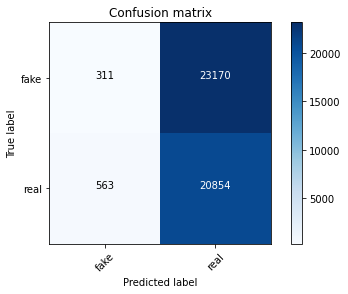

In [ ]:
cm = metrics.confusion_matrix(X_test['label'], prediction)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 3 - Dataset 2

In [ ]:
# Dataset 2
X_test = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_test = pre_process(X_test)
X_test.drop(["author"],axis=1,inplace=True)
X_test.drop(["id"],axis=1,inplace=True)

In [ ]:
# Metrics
prediction = model.predict(X_test["text"])

In [ ]:
prediction2 = np.array([0 if i  == "true" else 1 for i in prediction])
prediction2

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(X_test["label"], prediction2)*100,2)))
print(classification_report(X_test["label"], prediction2))

accuracy: 48.14%
              precision    recall  f1-score   support

           0       0.49      0.86      0.62     10387
           1       0.43      0.11      0.17     10413

    accuracy                           0.48     20800
   macro avg       0.46      0.48      0.40     20800
weighted avg       0.46      0.48      0.40     20800



Confusion matrix, without normalization


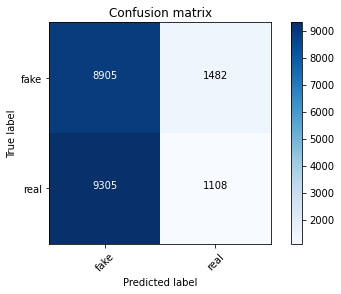

In [ ]:
cm = metrics.confusion_matrix(X_test["label"], prediction2)
confusion_matrix(cm, classes=['fake', 'real'])